In [14]:
from pathlib import Path

import torch
from torchlake.common.utils.image import load_image
from torchlake.common.models import VGGFeatureExtractor
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import save_img_array
from torchlake.common.utils.plot import plot_grids
from torchlake.style_transfer.models.neural_doodle import NeuralDoodle, MRFLoss
from torchlake.style_transfer.controller.trainer_neural_doodle import run_neural_doodle
from torchvision import transforms
import torchinfo

# setting


In [15]:
artifacts_path = Path("../../artifacts/neural-doodle")

In [16]:
DEVICE = torch.device("cuda:0")

# data


In [17]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [18]:
style = transform(load_image(artifacts_path.joinpath('style.jpg'))).unsqueeze(0).to(DEVICE)
style_mask = transform(load_image(artifacts_path.joinpath('semantic_map.png'))).unsqueeze(0).to(DEVICE)
input_mask = transform(load_image(artifacts_path.joinpath('input_map.png'))).unsqueeze(0).to(DEVICE)

# model


In [19]:
STYLE_LAYER_NAMES = ["3_1", "4_1"]

In [20]:
MASK_WEIGHT = 5e2

In [21]:
feature_extractor = VGGFeatureExtractor("vgg19", "relu", trainable=False).to(DEVICE)

In [22]:
model = NeuralDoodle(
    feature_extractor,
    STYLE_LAYER_NAMES,
    mask_weight=MASK_WEIGHT,
)

In [23]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
NeuralDoodle                             --
├─VGGFeatureExtractor: 1-1               --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  (1,792)
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  (36,928)
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    │    └─Conv2d: 3-6                  (73,856)
│    │    └─ReLU: 3-7                    --
│    │    └─Conv2d: 3-8                  (147,584)
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    │    └─Conv2d: 3-11                 (295,168)
│    │    └─ReLU: 3-12                   --
│    │    └─Conv2d: 3-13                 (590,080)
│    │    └─ReLU: 3-14                   --
│    │    └─Conv2d: 3-15                 (590,080)
│    │    └─ReLU: 3-16                   --
│    │    └─Conv2d: 3-17                 (590,080)
│    │    └─ReLU: 3

# train


In [10]:
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 1
SMOOTHNESS = 1

In [11]:
criterion = MRFLoss(CONTENT_WEIGHT, STYLE_WEIGHT, SMOOTHNESS)

In [24]:
output = run_neural_doodle(model, criterion, style, style_mask, input_mask, max_scale=1)

scales: [[69, 46], [138, 92], [276, 184], [552, 368]]
phases 1 begins
0      Total Loss: 16596237.000000 Style Loss : 16596237.000000
50     Total Loss: 3533825.000000 Style Loss : 3533825.000000
100    Total Loss: 3164762.500000 Style Loss : 3164762.500000
150    Total Loss: 2864317.000000 Style Loss : 2864317.000000
200    Total Loss: 2748316.250000 Style Loss : 2748316.250000
250    Total Loss: 2538738.500000 Style Loss : 2538738.500000
300    Total Loss: 2485355.000000 Style Loss : 2485355.000000
phases 2 begins
0      Total Loss: 72257304.000000 Style Loss : 72257304.000000
50     Total Loss: 9171361.000000 Style Loss : 9171361.000000
100    Total Loss: 7966177.000000 Style Loss : 7966177.000000
150    Total Loss: 7518872.000000 Style Loss : 7518872.000000
200    Total Loss: 7250449.000000 Style Loss : 7250449.000000
250    Total Loss: 7112425.000000 Style Loss : 7112425.000000
300    Total Loss: 7024015.000000 Style Loss : 7024015.000000
phases 3 begins
0      Total Loss: 1707473

# visualize


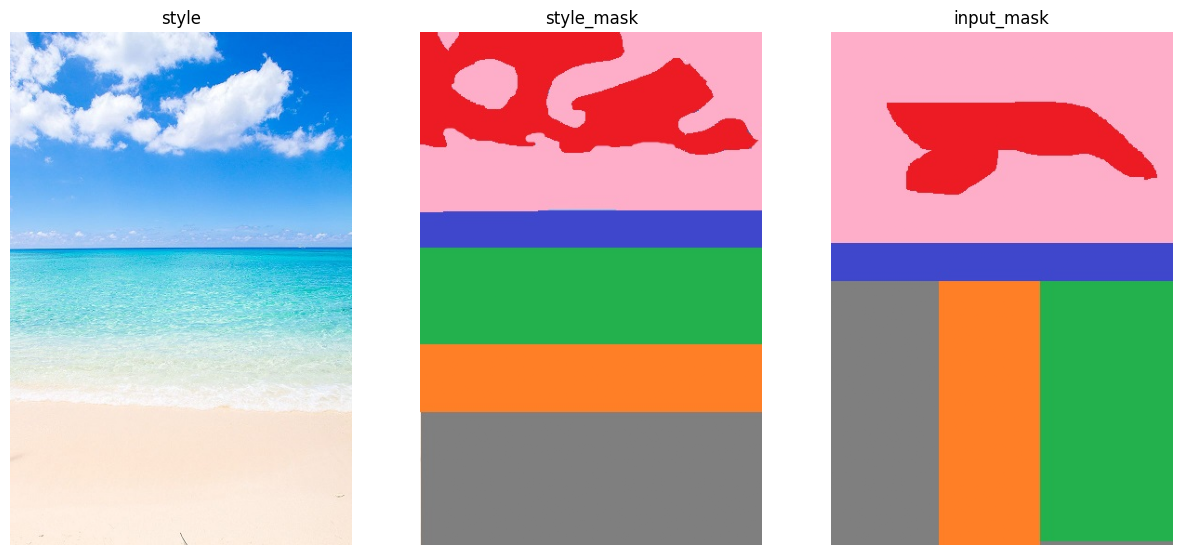

In [25]:
plot_grids(
    [img_tensor_to_np(style), img_tensor_to_np(style_mask), img_tensor_to_np(input_mask)],
    ["style", "style_mask", "input_mask"],
    1,
    3,
    figsize=(15, 15),
)

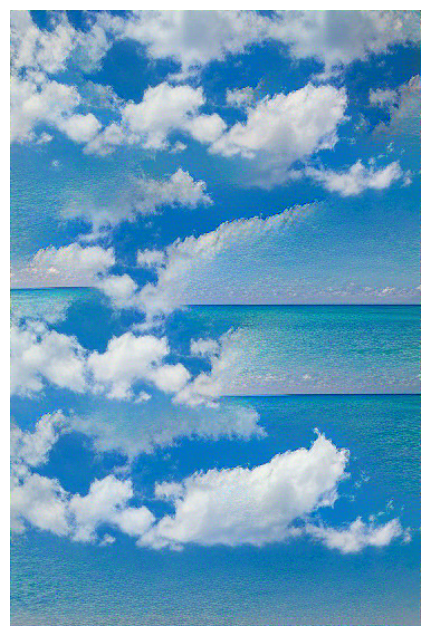

In [26]:
plot_grids([img_tensor_to_np(output)])


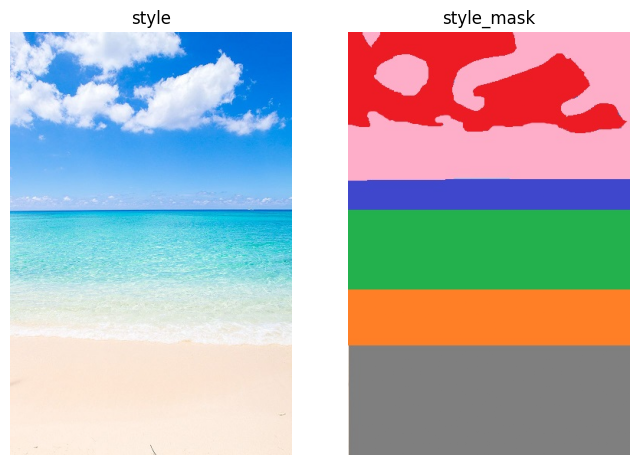

In [27]:
plot_grids(
    [img_tensor_to_np(style), img_tensor_to_np(style_mask)],
    ["style", "style_mask"],
    1,
    2,
    figsize=(8, 8),
)

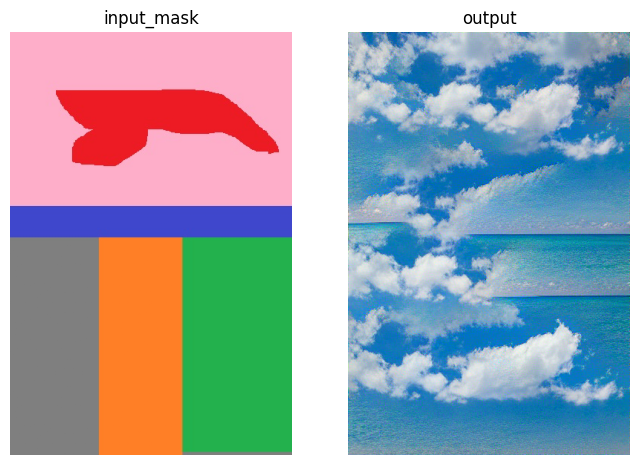

In [28]:
plot_grids(
    [img_tensor_to_np(input_mask), img_tensor_to_np(output)],
    ["input_mask", "output"],
    1,
    2,
    figsize=(8, 8),
)

In [29]:
output_path = artifacts_path.joinpath("output.png")

In [33]:
save_img_array(img_tensor_to_np(output)[:, :, ::-1], output_path.as_posix())